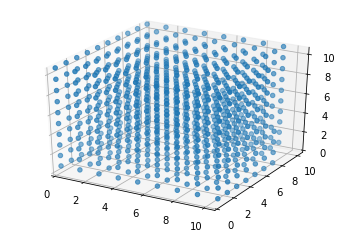

In [129]:
#starting configuration
import numpy as np
N = 864
rho = 0.75
L = (N/rho) ** (1./3.)
tau = 0.032

xn0 = []
yn0 = []
zn0 = []
for i in np.linspace(0, L, 9):
    for j in np.linspace(0.5, L, 10):
        for k in np.linspace(0.5, L, 10):
            xn0.append(i)
            yn0.append(j)
            zn0.append(k)
xn0 = np.array(xn0[:N])
yn0 = np.array(yn0[:N])
zn0 = np.array(zn0[:N])
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_zlim(0, L)

ax.scatter(xn0, yn0, zn0)

In [1]:
import numpy as np
import csv

outE = open('liquidargondata/firsttherm/E.csv', 'w+')
outE.write('n,Un,Kn\n')
xfile = open('liquidargondata/firsttherm/x.csv', 'w+', newline='')
xwr = csv.writer(xfile)
yfile = open('liquidargondata/firsttherm/y.csv', 'w+', newline='')
ywr = csv.writer(yfile)
zfile = open('liquidargondata/firsttherm/z.csv', 'w+', newline='')
zwr = csv.writer(zfile)
vxfile = open('liquidargondata/firsttherm/vx.csv', 'w+', newline='')
vxwr = csv.writer(vxfile)
vyfile = open('liquidargondata/firsttherm/vy.csv', 'w+', newline='')
vywr = csv.writer(vyfile)
vzfile = open('liquidargondata/firsttherm/vz.csv', 'w+', newline='')
vzwr = csv.writer(vzfile)

N = 864
rho = 0.75
L = (N/rho) ** (1./3.)
tau = 0.032

#all particles start at rest
vxn0 = np.zeros(N) #v_x_n
vxn1 = np.zeros(N) #v_x_n+1/2
vyn0 = np.zeros(N)
vyn1 = np.zeros(N)
vzn0 = np.zeros(N)
vzn1 = np.zeros(N)

#particles start at regular intervals
xn0 = []
yn0 = []
zn0 = []
for i in np.linspace(0., L-1.05, 9):
    for j in np.linspace(0., L-1.05, 10):
        for k in np.linspace(0., L-1.05, 10):
            xn0.append(i)
            yn0.append(j)
            zn0.append(k)
xn0 = np.array(xn0[:N])
yn0 = np.array(yn0[:N])
zn0 = np.array(zn0[:N])
xn1 = np.zeros(N)
yn1 = np.zeros(N)
zn1 = np.zeros(N)

fxn = np.zeros(N)
fyn = np.zeros(N)
fzn = np.zeros(N)

r = np.zeros((N, N))
ximagelocs = np.zeros((N, N))
yimagelocs = np.zeros((N, N))
zimagelocs = np.zeros((N, N))

def relax(x, y, z):
    Fstep(x, y, z)
    x = (x + 0.05*fxn) % L
    y = (y + 0.05*fyn) % L
    z = (z + 0.05*fzn) % L
    return x, y, z

def Fstep(xin, yin, zin):
    xx = np.repeat(xin, N).reshape(N, N)
    yy = np.repeat(yin, N).reshape(N, N)
    zz = np.repeat(zin, N).reshape(N, N)
    images = []
    for ximage in (-1, 0, 1):
        for yimage in (-1, 0, 1):
            for zimage in (-1, 0, 1):
                images.append((xx-xx.T+L*ximage)**2 + (yy-yy.T+L*yimage)**2 + (zz-zz.T+L*zimage)**2)
    global r, ximagelocs, yimagelocs, zimagelocs
    r = np.sqrt(np.minimum.reduce(images))
    ximagelocs = np.argmin(images, axis=0) // 9 - 1
    yimagelocs = np.argmin(images, axis=0) % 9 // 3 - 1
    zimagelocs = np.argmin(images, axis=0) % 3 - 1
    #r-dependent term in the force expression; couldn't decide what to call it, so just went with 'a'
    a = np.nan_to_num((1/r)**14 - 0.5*(1/r)**8)
    bx = (xin*a).T
    by = (yin*a).T
    bz = (zin*a).T
    for i in range(N):
        fxn[i] = np.sum(bx[i]) - np.dot(xin - ximagelocs[i]*L, a[i])
        fyn[i] = np.sum(by[i]) - np.dot(yin - yimagelocs[i]*L, a[i])
        fzn[i] = np.sum(bz[i]) - np.dot(zin - zimagelocs[i]*L, a[i])

#step forward the r=(x,y,z) values
def rstep(xin, yin, zin, vxin, vyin, vzin):
    xout = (xin + vxin*tau + fxn*(tau**2)/2) % L
    yout = (yin + vyin*tau + fyn*(tau**2)/2) % L
    zout = (zin + vzin*tau + fzn*(tau**2)/2) % L
    return xout, yout, zout

#step forward the v=(vx, vy, vz) values
def vstep(vxin, vyin, vzin):
    vxout = vxin + fxn * (tau/2)
    vyout = vyin + fyn * (tau/2)
    vzout = vzin + fzn * (tau/2)
    return vxout, vyout, vzout

def U():
    u0 = r**(-12)
    u0[u0 == np.inf] = 0
    u1 = r**(-6)
    u1[u1 == np.inf] = 0
    return 4*(np.sum(u0) - np.sum(u1))/2

def K(vxin, vyin, vzin):
    return 24 * np.sum(vxin**2 + vyin**2 + vzin**2)

def writevals(iteration):
    if iteration % 2 == 0:
        xwr.writerow(xn0)
        ywr.writerow(yn0)
        zwr.writerow(zn0)
    else:
        xwr.writerow(xn1)
        ywr.writerow(yn1)
        zwr.writerow(zn1)
    vxwr.writerow(vxn0)
    vywr.writerow(vyn0)
    vzwr.writerow(vzn0)

iterations = 1000
Fstep(xn0, yn0, zn0) #set F_0
for iteration in range(iterations):
    if iteration % 10 == 0:
        print(iteration)
        ue = U() #calculate U_{n} from r_{n}
        ke = K(vxn0, vyn0, vzn0) #calculate K_{n} from v_{n}
        print(f'U = {ue}, K = {ke}')
        outE.write(str(iteration) + ',' + str(ue) + ',' + str(ke) + '\n')
        writevals(iteration)
        
    vxn1, vyn1, vzn1 = vstep(vxn0, vyn0, vzn0) #set v_{n} -> v_{n+1/2}
    if iteration % 2 == 0:
        xn1, yn1, zn1 = rstep(xn0, yn0, zn0, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn1, yn1, zn1) #set F_{n} -> F_{n+1}
    else:
        xn0, yn0, zn0 = rstep(xn1, yn1, zn1, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn0, yn0, zn0) #set F_{n} -> F_{n+1}
    vxn0, vyn0, vzn0 = vstep(vxn1, vyn1, vzn1) #set v_{n+1/2} -> v_{n+1}

outE.close()
xfile.close()
yfile.close()
zfile.close()
vxfile.close()
vyfile.close()
vzfile.close()

In [203]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('E.csv', index_col='n')
df

,Un,Kn
n,,
0,-4335.169316,0.000000
10,-4347.233053,12.047438
20,-4364.645178,29.454060
30,-4374.638903,39.451883
40,-4380.423012,45.238434
...,...,...
950,-4966.835217,631.447615
960,-4955.741606,620.346006
970,-4953.909420,618.545703


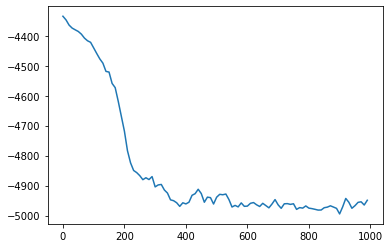

In [204]:
plt.plot(df['Un'])

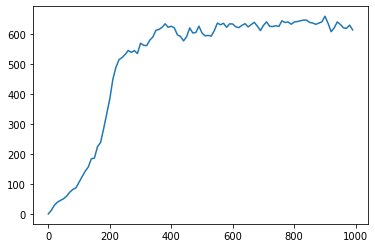

In [205]:
plt.plot(df['Kn'])

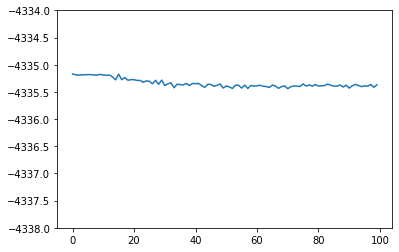

In [215]:
plt.ylim(-4338, -4334)
plt.plot(np.array(df['Un']) + np.array(df['Kn']))

In [218]:
T = K(vxn0, vyn0, vzn0) * (2/3) / N
T
#we find the temperature is too low (we want T = 1.069), so we rescale the velocities after thermalization and rerun

0.46898729492697666

In [5]:
#reads in the values from where the simulation ended
with open('liquidargondata/firsttherm/x.csv', newline='') as xfile:
    xn0 = np.array(list(csv.reader(xfile))[-1], dtype=np.float64)
with open('liquidargondata/firsttherm/y.csv', newline='') as yfile:
    yn0 = np.array(list(csv.reader(yfile))[-1], dtype=np.float64)
with open('liquidargondata/firsttherm/z.csv', newline='') as zfile:
    zn0 = np.array(list(csv.reader(zfile))[-1], dtype=np.float64)
with open('liquidargondata/firsttherm/vx.csv', newline='') as vxfile:
    vxn0 = np.array(list(csv.reader(vxfile))[-1], dtype=np.float64)
with open('liquidargondata/firsttherm/vy.csv', newline='') as vyfile:
    vyn0 = np.array(list(csv.reader(vyfile))[-1], dtype=np.float64)
with open('liquidargondata/firsttherm/vz.csv', newline='') as vzfile:
    vzn0 = np.array(list(csv.reader(vzfile))[-1], dtype=np.float64)

outE = open('liquidargondata/secondtherm/E.csv', 'w+')
outE.write('n,Un,Kn\n')
xfile = open('liquidargondata/secondtherm/x.csv', 'w+', newline='')
xwr = csv.writer(xfile)
yfile = open('liquidargondata/secondtherm/y.csv', 'w+', newline='')
ywr = csv.writer(yfile)
zfile = open('liquidargondata/secondtherm/z.csv', 'w+', newline='')
zwr = csv.writer(zfile)
vxfile = open('liquidargondata/secondtherm/vx.csv', 'w+', newline='')
vxwr = csv.writer(vxfile)
vyfile = open('liquidargondata/secondtherm/vy.csv', 'w+', newline='')
vywr = csv.writer(vyfile)
vzfile = open('liquidargondata/secondtherm/vz.csv', 'w+', newline='')
vzwr = csv.writer(vzfile)

vxn0 = vxn0 * 1.65 #rescale the velocities to increase KE and T
vyn0 = vyn0 * 1.65
vzn0 = vzn0 * 1.65

iterations = 500
Fstep(xn0, yn0, zn0) #set F_0
for iteration in range(iterations):
    if iteration % 10 == 0:
        print(iteration)
        ue = U() #calculate U_{n} from r_{n}
        ke = K(vxn0, vyn0, vzn0) #calculate K_{n} from v_{n}
        print(f'U = {ue}, K = {ke}')
        outE.write(str(iteration) + ',' + str(ue) + ',' + str(ke) + '\n')
        writevals(iteration)
        
    vxn1, vyn1, vzn1 = vstep(vxn0, vyn0, vzn0) #set v_{n} -> v_{n+1/2}
    if iteration % 2 == 0:
        xn1, yn1, zn1 = rstep(xn0, yn0, zn0, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn1, yn1, zn1) #set F_{n} -> F_{n+1}
    else:
        xn0, yn0, zn0 = rstep(xn1, yn1, zn1, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn0, yn0, zn0) #set F_{n} -> F_{n+1}
    vxn0, vyn0, vzn0 = vstep(vxn1, vyn1, vzn1) #set v_{n+1/2} -> v_{n+1}

outE.close()
xfile.close()
yfile.close()
zfile.close()
vxfile.close()
vyfile.close()
vzfile.close()

C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in subtract


0
U = -4948.759763323499, K = 1669.9538285790159


C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in power
C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in power


10
U = -4634.172895385619, K = 1355.9552997520263
20
U = -4564.739962833276, K = 1286.1909583840288
30
U = -4628.484705010097, K = 1349.827666656025
40
U = -4573.7693746678615, K = 1295.2735649342533
50
U = -4578.854253563373, K = 1300.325830209039
60
U = -4541.08605380847, K = 1262.6423593328777
70
U = -4571.6855680560275, K = 1293.065460278574
80
U = -4575.129778424725, K = 1296.5823369479742
90
U = -4549.906094767255, K = 1271.3523577471517
100
U = -4544.270250914592, K = 1265.782658619297
110
U = -4572.525377608081, K = 1293.950437852714
120
U = -4556.874926919433, K = 1278.433549535783
130
U = -4562.320678983894, K = 1283.8187731594055
140
U = -4526.713118104735, K = 1248.2774052837244
150
U = -4541.254637526763, K = 1262.727336041729
160
U = -4558.238896347025, K = 1279.716537146476
170
U = -4534.056604886276, K = 1255.5704189393687
180
U = -4535.956165769642, K = 1257.4823806413406
190
U = -4531.227834178601, K = 1252.795160065216
200
U = -4514.110631215848, K = 1235.69757295334

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('liquidargondata/secondtherm/E.csv', index_col='n')
df

,Un,Kn
n,,
0,-4948.759763,1669.953829
10,-4634.172895,1355.955300
20,-4564.739963,1286.190958
30,-4628.484705,1349.827667
40,-4573.769375,1295.273565
50,-4578.854254,1300.325830
60,-4541.086054,1262.642359
70,-4571.685568,1293.065460
80,-4575.129778,1296.582337


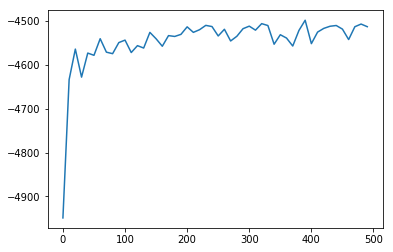

In [7]:
plt.plot(df['Un'])

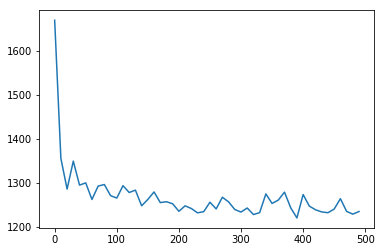

In [8]:
plt.plot(df['Kn'])

In [9]:
T = K(vxn0, vyn0, vzn0) * (2/3) / N
T
#the temperature is still a bit too small

0.9738222655532525

In [11]:
#reads in the values from where the simulation ended
with open('liquidargondata/secondtherm/x.csv', newline='') as xfile:
    xn0 = np.array(list(csv.reader(xfile))[-1], dtype=np.float64)
with open('liquidargondata/secondtherm/y.csv', newline='') as yfile:
    yn0 = np.array(list(csv.reader(yfile))[-1], dtype=np.float64)
with open('liquidargondata/secondtherm/z.csv', newline='') as zfile:
    zn0 = np.array(list(csv.reader(zfile))[-1], dtype=np.float64)
with open('liquidargondata/secondtherm/vx.csv', newline='') as vxfile:
    vxn0 = np.array(list(csv.reader(vxfile))[-1], dtype=np.float64)
with open('liquidargondata/secondtherm/vy.csv', newline='') as vyfile:
    vyn0 = np.array(list(csv.reader(vyfile))[-1], dtype=np.float64)
with open('liquidargondata/secondtherm/vz.csv', newline='') as vzfile:
    vzn0 = np.array(list(csv.reader(vzfile))[-1], dtype=np.float64)

outE = open('liquidargondata/thirdtherm/E.csv', 'w+')
outE.write('n,Un,Kn\n')
xfile = open('liquidargondata/thirdtherm/x.csv', 'w+', newline='')
xwr = csv.writer(xfile)
yfile = open('liquidargondata/thirdtherm/y.csv', 'w+', newline='')
ywr = csv.writer(yfile)
zfile = open('liquidargondata/thirdtherm/z.csv', 'w+', newline='')
zwr = csv.writer(zfile)
vxfile = open('liquidargondata/thirdtherm/vx.csv', 'w+', newline='')
vxwr = csv.writer(vxfile)
vyfile = open('liquidargondata/thirdtherm/vy.csv', 'w+', newline='')
vywr = csv.writer(vyfile)
vzfile = open('liquidargondata/thirdtherm/vz.csv', 'w+', newline='')
vzwr = csv.writer(vzfile)

vxn0 = vxn0 * 1.1 #rescale the velocities to increase KE and T
vyn0 = vyn0 * 1.1
vzn0 = vzn0 * 1.1

iterations = 500
Fstep(xn0, yn0, zn0) #set F_0
for iteration in range(iterations):
    if iteration % 10 == 0:
        print(iteration)
        ue = U() #calculate U_{n} from r_{n}
        ke = K(vxn0, vyn0, vzn0) #calculate K_{n} from v_{n}
        print(f'U = {ue}, K = {ke}')
        outE.write(str(iteration) + ',' + str(ue) + ',' + str(ke) + '\n')
        writevals(iteration)
        
    vxn1, vyn1, vzn1 = vstep(vxn0, vyn0, vzn0) #set v_{n} -> v_{n+1/2}
    if iteration % 2 == 0:
        xn1, yn1, zn1 = rstep(xn0, yn0, zn0, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn1, yn1, zn1) #set F_{n} -> F_{n+1}
    else:
        xn0, yn0, zn0 = rstep(xn1, yn1, zn1, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn0, yn0, zn0) #set F_{n} -> F_{n+1}
    vxn0, vyn0, vzn0 = vstep(vxn1, vyn1, vzn1) #set v_{n+1/2} -> v_{n+1}

outE.close()
xfile.close()
yfile.close()
zfile.close()
vxfile.close()
vyfile.close()
vzfile.close()

C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in subtract


0
U = -4513.764227286774, K = 1494.6736406835016


C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in power
C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in power


10
U = -4475.579441794884, K = 1456.7743271523443
20
U = -4418.762270995875, K = 1399.9846564315235
30
U = -4434.177482327895, K = 1415.166314106776
40
U = -4444.696896172487, K = 1425.7399679351329
50
U = -4453.497564424937, K = 1434.5074370498196
60
U = -4435.943702622454, K = 1416.988536345283
70
U = -4432.825755499516, K = 1413.8864863242002
80
U = -4439.348590552833, K = 1420.3068273384447
90
U = -4386.831652325691, K = 1367.9568684619014
100
U = -4456.423609685069, K = 1437.3782513596075
110
U = -4442.938524973486, K = 1424.0264971388435
120
U = -4456.8419083819235, K = 1437.7569081331726
130
U = -4433.9581228389, K = 1414.8983849281499
140
U = -4410.4725834075, K = 1391.5533656259422
150
U = -4411.35296842547, K = 1392.4047192834792
160
U = -4406.289279864779, K = 1387.4298475261198
170
U = -4446.8484682499375, K = 1427.9884406158951
180
U = -4457.009243700956, K = 1438.1517402410534
190
U = -4434.371031760687, K = 1415.5853936806147
200
U = -4444.037760333727, K = 1425.14633110

In [12]:
df = pd.read_csv('liquidargondata/thirdtherm/E.csv', index_col='n')
df['T'] = [K * (2/3) / N for K in df['Kn'].tolist()]
df

,Un,Kn,T
n,,,
0,-4513.764227,1494.673641,1.153298
10,-4475.579442,1456.774327,1.124054
20,-4418.762271,1399.984656,1.080235
30,-4434.177482,1415.166314,1.091949
40,-4444.696896,1425.739968,1.100108
50,-4453.497564,1434.507437,1.106873
60,-4435.943703,1416.988536,1.093355
70,-4432.825755,1413.886486,1.090962
80,-4439.348591,1420.306827,1.095916


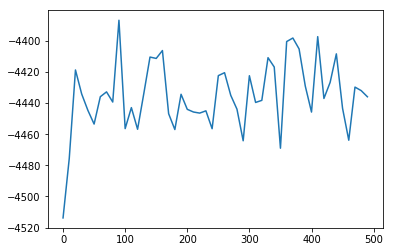

In [13]:
plt.plot(df['Un'])

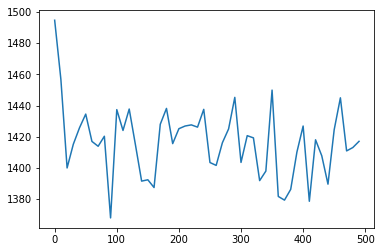

In [14]:
plt.plot(df['Kn'])

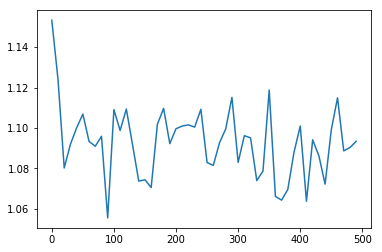

In [15]:
plt.plot(df['T'])

In [18]:
#reads in the values from where the simulation ended
with open('liquidargondata/thirdtherm/x.csv', newline='') as xfile:
    xn0 = np.array(list(csv.reader(xfile))[-1], dtype=np.float64)
with open('liquidargondata/thirdtherm/y.csv', newline='') as yfile:
    yn0 = np.array(list(csv.reader(yfile))[-1], dtype=np.float64)
with open('liquidargondata/thirdtherm/z.csv', newline='') as zfile:
    zn0 = np.array(list(csv.reader(zfile))[-1], dtype=np.float64)
with open('liquidargondata/thirdtherm/vx.csv', newline='') as vxfile:
    vxn0 = np.array(list(csv.reader(vxfile))[-1], dtype=np.float64)
with open('liquidargondata/thirdtherm/vy.csv', newline='') as vyfile:
    vyn0 = np.array(list(csv.reader(vyfile))[-1], dtype=np.float64)
with open('liquidargondata/thirdtherm/vz.csv', newline='') as vzfile:
    vzn0 = np.array(list(csv.reader(vzfile))[-1], dtype=np.float64)

outE = open('liquidargondata/fourththerm/E.csv', 'w+')
outE.write('n,Un,Kn\n')
xfile = open('liquidargondata/fourththerm/x.csv', 'w+', newline='')
xwr = csv.writer(xfile)
yfile = open('liquidargondata/fourththerm/y.csv', 'w+', newline='')
ywr = csv.writer(yfile)
zfile = open('liquidargondata/fourththerm/z.csv', 'w+', newline='')
zwr = csv.writer(zfile)
vxfile = open('liquidargondata/fourththerm/vx.csv', 'w+', newline='')
vxwr = csv.writer(vxfile)
vyfile = open('liquidargondata/fourththerm/vy.csv', 'w+', newline='')
vywr = csv.writer(vyfile)
vzfile = open('liquidargondata/fourththerm/vz.csv', 'w+', newline='')
vzwr = csv.writer(vzfile)

vxn0 = vxn0 * 0.97 #rescale the velocities to increase KE and T
vyn0 = vyn0 * 0.97
vzn0 = vzn0 * 0.97

iterations = 2000
Fstep(xn0, yn0, zn0) #set F_0
for iteration in range(iterations):
    if iteration % 10 == 0:
        print(iteration)
        ue = U() #calculate U_{n} from r_{n}
        ke = K(vxn0, vyn0, vzn0) #calculate K_{n} from v_{n}
        print(f'U = {ue}, K = {ke}')
        outE.write(str(iteration) + ',' + str(ue) + ',' + str(ke) + '\n')
        writevals(iteration)
        
    vxn1, vyn1, vzn1 = vstep(vxn0, vyn0, vzn0) #set v_{n} -> v_{n+1/2}
    if iteration % 2 == 0:
        xn1, yn1, zn1 = rstep(xn0, yn0, zn0, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn1, yn1, zn1) #set F_{n} -> F_{n+1}
    else:
        xn0, yn0, zn0 = rstep(xn1, yn1, zn1, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn0, yn0, zn0) #set F_{n} -> F_{n+1}
    vxn0, vyn0, vzn0 = vstep(vxn1, vyn1, vzn1) #set v_{n+1/2} -> v_{n+1}

outE.close()
xfile.close()
yfile.close()
zfile.close()
vxfile.close()
vyfile.close()
vzfile.close()

C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in subtract


0
U = -4435.977942636352, K = 1333.3018375775964


C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in power
C:\Users\Joheen\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in power


10
U = -4428.26415434673, K = 1325.5238708510683
20
U = -4395.529029265003, K = 1292.8915760355187
30
U = -4452.860867433492, K = 1349.9708478575085
40
U = -4431.95292552868, K = 1329.2857779857848
50
U = -4435.641046087925, K = 1332.9169085213464
60
U = -4441.587360528983, K = 1338.9180115739764
70
U = -4482.264577916529, K = 1379.477500714192
80
U = -4463.847898451782, K = 1361.1331043968817
90
U = -4485.164110047661, K = 1382.3670504465535
100
U = -4439.989628369227, K = 1337.4255566587235
110
U = -4437.22838977065, K = 1334.5117968108448
120
U = -4439.508827183388, K = 1336.7527921038534
130
U = -4410.043810219686, K = 1307.4562882252549
140
U = -4474.866538647203, K = 1372.0969493223843
150
U = -4441.723848865472, K = 1339.147329523666
160
U = -4477.305195061953, K = 1374.5157074081674
170
U = -4461.6955981352385, K = 1359.0182953004671
180
U = -4450.231228885909, K = 1347.5452402364497
190
U = -4452.216415821296, K = 1349.4972837452372
200
U = -4441.185913679466, K = 1338.4661616

1620
U = -4456.546737154793, K = 1353.869153869321
1630
U = -4440.23390045404, K = 1337.5594375450175
1640
U = -4471.7754151804465, K = 1369.0089887189354
1650
U = -4474.841829318039, K = 1372.2179136006303
1660
U = -4486.518867661586, K = 1383.7572685905157
1670
U = -4462.0028035823525, K = 1359.3514988538063
1680
U = -4446.307934891438, K = 1343.6670417579962
1690
U = -4460.740786281371, K = 1357.999886056675
1700
U = -4434.584764736183, K = 1331.812082128541
1710
U = -4417.382099880741, K = 1314.6665815876174
1720
U = -4457.429049962607, K = 1354.6767084470862
1730
U = -4456.517516327964, K = 1353.7977611803576
1740
U = -4433.714672272826, K = 1331.0827598226715
1750
U = -4436.095254323792, K = 1333.4188118637526
1760
U = -4429.104882821502, K = 1326.4083333218641
1770
U = -4449.926513647672, K = 1347.1386743839278
1780
U = -4431.738639743674, K = 1328.9254828606358
1790
U = -4430.849675605404, K = 1328.060380161537
1800
U = -4457.888991307967, K = 1355.1802965165189
1810
U = -4436.